In [1]:
from functools import partial
from typing import Callable

import arviz
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import pandas as pd
import polars as pl
import scipy.linalg
import scipy.optimize as opt
import scipy.spatial
import seaborn as sns
from jax import Array
from numpyro import distributions as dist
from scipy import stats
from tqdm.notebook import tqdm

In [2]:
@partial(jax.jit, static_argnames="feature_dim")
def gaussian_kernel(x: Array, y: Array, gamma: float = 10, feature_dim: int = None):
    if len(x.shape) == 1:
        x = x.reshape((-1, 1))
    if len(y.shape) == 1:
        y = y.reshape((1, -1))

    if feature_dim is None:
        res = jnp.exp(-gamma * (x - y) ** 2)
    else:
        res = jnp.exp(-gamma * jnp.linalg.norm(x - y, axis=feature_dim) ** 2)
    return res


ex_axis = jnp.array([0, 0.5], dtype=float).reshape((1, 2))
gaussian_kernel(ex_axis, ex_axis, feature_dim=1)

Array([1.], dtype=float32)

In [3]:
@partial(jax.jit, static_argnames="n_samples")
def gaussian_process_prior(key: Array, gamma: float = 10, n_samples: int = 1):
    xs = jnp.linspace(0, 1, num=101)
    cov = gaussian_kernel(xs.reshape((-1, 1)), xs.reshape((1, -1)), gamma=gamma)
    means = jnp.zeros_like(xs)
    return jax.random.multivariate_normal(
        key, means, cov, shape=(n_samples,), method="svd"
    )

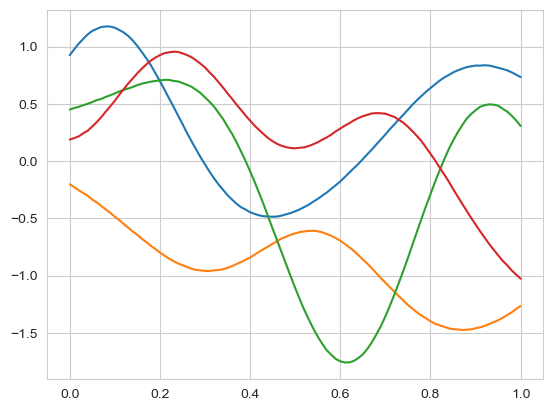

In [4]:
x_axis = jnp.linspace(0, 1, num=101)
samples = gaussian_process_prior(jax.random.key(0), n_samples=4, gamma=10)
for sample in samples:
    plt.plot(x_axis, sample)

In [5]:
@partial(jax.jit, static_argnames=("a", "b"))
def special_kernel_block(x: Array, y: Array, a: float = 0, b: float = 0):
    assert len(x.shape) == len(y.shape) == 1
    return (1 + x @ y.T) ** 2 + a * (
        jnp.sin(2 * jnp.pi * x.flatten() + b).reshape((-1, 1))
        * jnp.sin(2 * jnp.pi * y.flatten() + b).reshape((1, -1))
    )

In [11]:
# load and normalize Mauna Loa data
data = np.genfromtxt("data/co2_mm_mlo.csv", delimiter=",")
# 10 years of data for learning
x_train = data[:120, 2] - 1958
y_raw = data[:120, 3]
y_mean = np.mean(y_raw)
y_std = np.sqrt(np.var(y_raw))
y_train = (y_raw - y_mean) / y_std
# the next 5 years for prediction
x_test = data[120:180, 2] - 1958
y_test_unnorm = data[120:180, 3]

In [7]:
def neg_log_likelihood(params, kernel_fn: Callable):
    noise_y, *kernel_params = params
    means = np.zeros_like(x_train)
    cov = kernel_fn(x_train, x_train, *kernel_params) + noise_y * np.identity(
        len(means)
    )
    try:
        nll = -stats.multivariate_normal(means, cov).logpdf(y_train)
    except ValueError:
        nll = -float("inf")
    return nll


def optimize_params(
    search_ranges: tuple[tuple[float, float], ...], kernel_fn: Callable, grid_size: int
):
    opt_params = opt.brute(
        partial(neg_log_likelihood, kernel_fn=kernel_fn),
        search_ranges,
        Ns=grid_size,
        finish=None,
    )
    return opt_params[0], opt_params[1:]


def conditional(x_star: Array, noise_y: float, kernel_params, kernel_fn: Callable):
    inverse_cov = np.linalg.inv(
        kernel_fn(x_train, x_train, *kernel_params)
        + noise_y * np.identity(len(x_train))
    )
    kernel_star = kernel_fn(x_train, x_star, *kernel_params)
    mu_star = kernel_star.T @ inverse_cov @ y_train
    cov_star = kernel_fn(x_star, x_star) - kernel_star.T @ inverse_cov @ kernel_star
    return mu_star, cov_star


kernel = gaussian_kernel
# Gaussian
noise_var, eta = optimize_params(
    search_ranges=((1.0e-4, 10), (1.0e-4, 10)), kernel_fn=kernel, grid_size=100
)
print("optimal params:", noise_var, eta)

optimal params: 0.10110909090909091 [9.79798182]


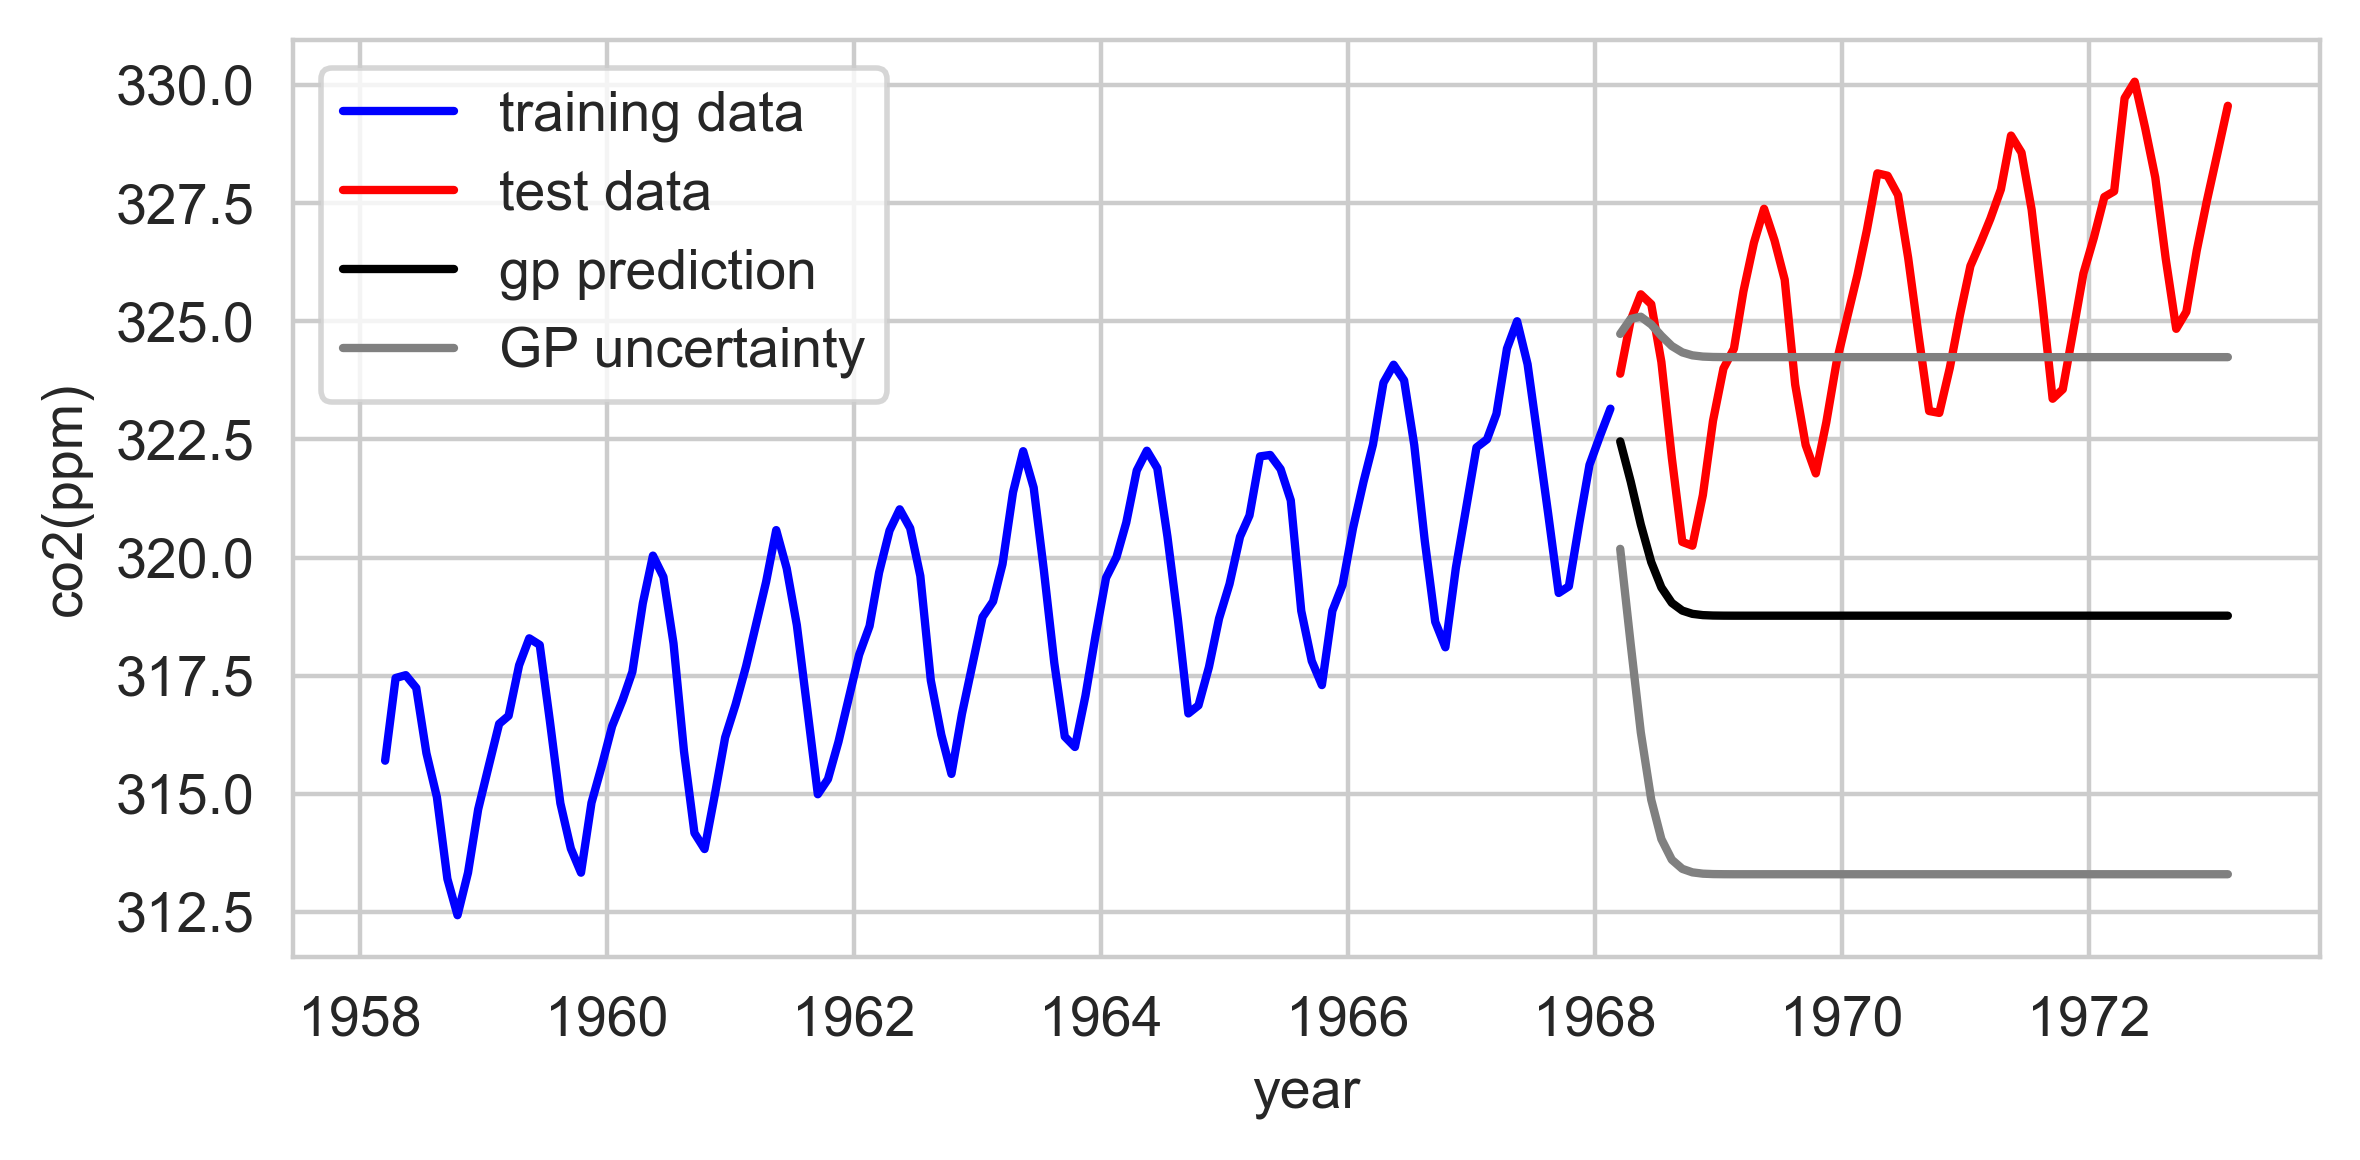

In [12]:
prediction_mean_gp, Sigma_gp = conditional(x_test, noise_var, eta, kernel)
plt.figure(dpi=400, figsize=(6, 3))
plt.plot(x_train + 1958, y_raw, color="blue", label="training data")
plt.plot(x_test + 1958, y_test_unnorm, color="red", label="test data")
cond_y_mean = prediction_mean_gp * y_std + y_mean
cond_y_var = np.diag(Sigma_gp) * y_std**2
plt.plot(x_test + 1958, cond_y_mean, color="black", label="gp prediction")
plt.plot(
    x_test + 1958,
    cond_y_mean + 1.96 * cond_y_var**0.5,
    color="grey",
    label="GP uncertainty",
)
plt.plot(x_test + 1958, cond_y_mean - 1.96 * cond_y_var**0.5, color="grey")
plt.xlabel("year")
plt.ylabel("co2(ppm)")
plt.legend()
plt.tight_layout()